<a href="https://colab.research.google.com/github/trevoradriaanse/ANLY590/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from IPython.core.display import SVG
import pandas as pd
%matplotlib inline

In [2]:
!pip install nnv

**Problem 1. (Feedfoward Network)**

1. Here is a network with two input units, one hidden layer with three hidden units using ReLU activations, and a one unit output layer for binary classification.

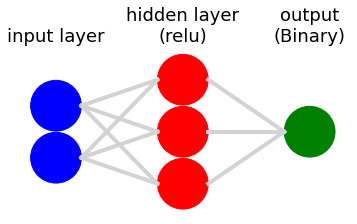

In [3]:
from nnv import NNV
%matplotlib inline

layersList = [
    {"title":"input layer", "units": 2, "color": "Blue"},
    {"title":"hidden layer\n(relu)", "units": 3,"color": "Red"},
    {"title":"output\n(Binary)", "units": 1,"color": "Green"},
]

plot = NNV(layersList).render(save_to_file="network_1.png")

2. We write out the mathematical equation for the output of this network below.

In the diagram above, imagine the two input nodes are labeled $x_1$ and $x_2$, the three hidden nodes are $h_1$, $h_2$, and $h_3$, and the output node is $\hat{y}$. The edges from the input layer to the hidden layer are labeled $w_{ij}$ for going from input $x_i$ to hidden node $h_j$, and the edges from the hidden layer to the output layer are $v_j$, from hidden unit $h_j$ to $\hat{y}$. The bias vector for the hidden layer is not shown, nor is the bias constant for the output layer.

Let $h_j = \max(0, a_j)$, where $a_j$ is a weighted sum from the previous layer plus a bias unit. That is,
$$
a_1 = w_{11}x_1 + w_{21}x_2 + b_1 \\
a_2 = w_{12}x_1 + w_{22}x_2 + b_2 \\
a_3 = w_{13}x_1 + w_{23}x_2 + b_3 \\
\Rightarrow a_j = w_{1j}x_1 + w_{2j}x_2 + b_j
$$

Similarly,

$$ \hat{y} = g(v_1h_1 + v_2h_2 + v_3h_3 + c), $$
where $g$ is the output function (in this case, for binary classification, $g$ is the sigmoid function). Expanding the above expression to show $\hat{y}$ as a function of all of the variables of the graph, we obtain
$$ \hat{y} = g\big[v_1\max(0, w_{11}x_1 + w_{21}x_2 + b_1) \\ + v_2\max(0, w_{12}x_1 + w_{22}x_2 + b_2) \\ + v_3\max(0, w_{13}x_1 + w_{23}x_2 + b_3) + c\large].$$

We can express this succinctly using matrix notation. If

$$ W = \begin{bmatrix}
w_{11} &w_{12} &w_{13}\\
w_{21} &w_{22} &w_{23}\\
\end{bmatrix}, \hspace{.5cm} \mathbf{x} = \begin{bmatrix} x_1 \\x_2 \end{bmatrix}, \hspace{.5cm} \mathbf{b} = \begin{bmatrix} b_1 \\b_2 \\b_3\end{bmatrix}, \hspace{.5cm} \mathbf{h} = \begin{bmatrix} h_1 \\h_2 \\h_3\end{bmatrix}, \hspace{.5cm} \text{and} \hspace{.5cm} \mathbf{v} = \begin{bmatrix} v_1 \\v_2 \\v_3\end{bmatrix},$$

then
$$
a_j = W^{\text{T}}\mathbf{x} + \mathbf{b}, \hspace{.5cm} h_j = \max(0, a_j), \hspace{.5cm} \text{and} \hspace{.5cm} \hat{y} = g(\mathbf{v}^{\text{T}}\cdot\mathbf{h} + c).
$$ For binary classification, we have
$$
\hat{y} = \sigma(\mathbf{v}^{\text{T}}\cdot\mathbf{h} + c).
$$


3. We write out the forward pass function.

In [4]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
relu = lambda x: np.maximum(0, x)

def ff_nn_relu(X, W, b, v, c):
    """Computes yhat given input data and model specification"""
    h = relu(np.dot(X, W) + b)
    return sigmoid(np.dot(h, v) + c)

4. If we have the parameter matrices 
$$ W = \begin{bmatrix}
1 &-1 &0\\
0 &0 &0.5\\
\end{bmatrix}, \hspace{.5cm} \mathbf{b} = [0, 0, 1]^{\text{T}}, \hspace{.5cm} \mathbf{v} = [1, 0, -1]^{\text{T}}, \hspace{.5cm} \text{and} \hspace{.5cm} c = 1,$$ with three inputs

$$ X = \begin{bmatrix}
1 &-1\\
0 &-1\\
0 &1\\
\end{bmatrix},$$
then we can compute the class probabilities associated with the forward pass for each example below.

In [5]:
W = np.array([[1, -1, 0],[0, 0, 0.5]])
X = np.array([[1, -1], [0, -1], [0, 1]])
b = np.array([0, 0, 1])
v = np.array([1, 0, -1])
c = np.array([1])

In [6]:
# W is 2x3 and X is 3x2
# To multiply W transpose times X,
# np.dot(X,W) computes three numbers
# h1, h2, h3 for two input numbers x1, x2
# For instance, [1, -1] from X is the first 
# example and that is multiplied across W
np.dot(X, W)

array([[ 1. , -1. , -0.5],
       [ 0. ,  0. , -0.5],
       [ 0. ,  0. ,  0.5]])

In [7]:
print(f"The output activations for the three examples are {ff_nn_relu(X, W, b, v, c)}.")

The output activations for the three examples are [0.81757448 0.62245933 0.37754067].


**Problem 2. (Gradient Descent)**

1. For the function
$$ f(x,y) = (1-x^3) + 100(y^2-x)^2$$
we compute the partial derivatives as
$$ \frac{\partial f}{\partial x}= -3x^2 - 200(y^2 - x)$$
and 
$$ \frac{\partial f}{\partial y}= 400*y(y^2 - x).$$

2. We create a visualization of the contours of $f(x,y)$ below.

In [8]:
def f(x, y):
    return (1 - x**3) + 100 * (y**2 - x)**2

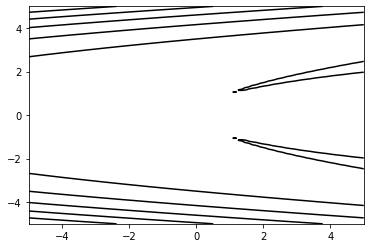

In [9]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
plt.contour(X, Y, Z, colors='black')

3. We write a Gradient Descent algorithm for finding the minimum of the function. We will also visualize results with a few different learning rates.

In [10]:
def grad_f(x, y):
    return -3*x**2 - 200*(y**2 - x), 400*y*(y**2 - x)

def gradient_descent(starting_point, iters, lr):
    x, y = starting_point
    trajectories = [starting_point]

    for it in range(iters):
        grad_f_x, grad_f_y = grad_f(x,y)
        x, y = x - lr*grad_f_x, y - lr*grad_f_y
        trajectories.append([x,y])
    return trajectories

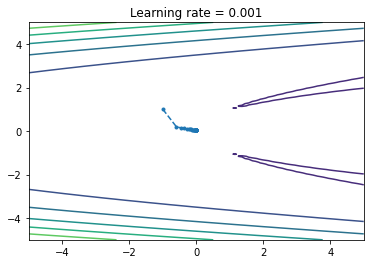

In [11]:
starting_point = [-1, 1]
results = gradient_descent(starting_point, iters=30, lr=0.001)
fig, ax = plt.subplots()
contour = ax.contour(X, Y, Z)
xs = [l[0] for l in results]
ys = [l[1] for l in results]
plt.title("Learning rate = 0.001")
plt.plot(xs, ys,'.--')

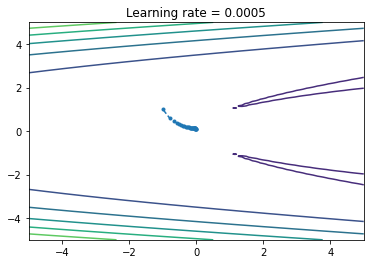

In [12]:
starting_point = [-1, 1]
results = gradient_descent(starting_point, iters=30, lr=0.0005)
fig, ax = plt.subplots()
contour = ax.contour(X, Y, Z)
xs = [l[0] for l in results]
ys = [l[1] for l in results]
plt.title("Learning rate = 0.0005")
plt.plot(xs, ys,'.--')

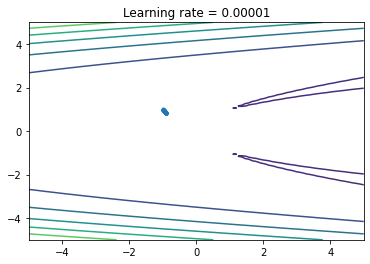

In [13]:
starting_point = [-1, 1]
results = gradient_descent(starting_point, iters=30, lr=0.00001)
fig, ax = plt.subplots()
contour = ax.contour(X, Y, Z)
xs = [l[0] for l in results]
ys = [l[1] for l in results]
plt.title("Learning rate = 0.00001")
plt.plot(xs, ys,'.--')

The plots above suggest that the choice of learning rate for the gradient descent algorithm can be quite significant to reaching a local minimum of the loss function. In the first two plots, the two learning rate choices seem to be reasonable because we approach the minimum. In the final example, with such a small learning rate, we take too few too small steps to ever reach a local min. If we bump up the number of iterations, then we would ultimately approach the min--albeit at a much slower pace.

4. Now, let's repeat what we've done above, but add in momentum to our optimization algorithm.

In [14]:
def gradient_descent_with_momentum(starting_point, iters, lr, initial_velocity, alpha):
    x, y = starting_point
    trajectories = [starting_point]
    velocity = initial_velocity
    for it in range(iters):
        grad_f_x, grad_f_y = grad_f(x,y)
        velocity[0] = alpha*velocity[0] - lr*grad_f_x
        velocity[1] = alpha*velocity[1] - lr*grad_f_y
        x = x + velocity[0]
        y = y + velocity[1]
        trajectories.append([x,y])
    return trajectories

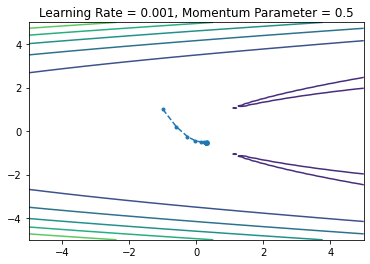

In [15]:
starting_point = [-1, 1]
results = gradient_descent_with_momentum(starting_point, iters=30, lr=0.001,
                           initial_velocity=[0,0], alpha=0.5)
fig, ax = plt.subplots()
contour = ax.contour(X, Y, Z)
xs = [l[0] for l in results]
ys = [l[1] for l in results]
plt.title("Learning Rate = 0.001, Momentum Parameter = 0.5")
plt.plot(xs, ys,'.--')

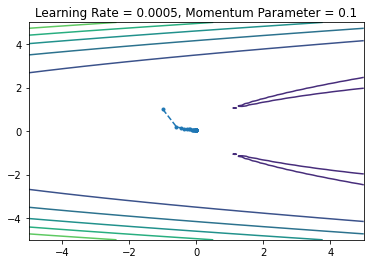

In [16]:
starting_point = [-1, 1]
results = gradient_descent_with_momentum(starting_point, iters=30, lr=0.001,
                           initial_velocity=[0,0], alpha=0.01)
fig, ax = plt.subplots()
contour = ax.contour(X, Y, Z)
xs = [l[0] for l in results]
ys = [l[1] for l in results]
plt.title("Learning Rate = 0.0005, Momentum Parameter = 0.1")
plt.plot(xs, ys,'.--')

When we use momentum, we can use previous gradient information to converge faster. In the first plot, with $\alpha=0.05$, we se that convergence to a local min occurs rather quickly. But in the second plot, with a smaller hyperparameter choice for the momentum parameter ($\alpha=0.01$), we see the convergence isn't as fast because we are capitalizing less on the momentum from past gradients.

**Problem 3. (Backprop)**

1. Now we derive expressions for the gradient of the loss with respect to each of the model parameters for the network introduced in Problem 1.


Set as the input into the $j^{\text{th}}$ unit of layer $\ell$ 

$$ z_j^\ell = \sum_k w_{jk}^\ell a_k^{\ell-1} + b_j^\ell,$$

where we adopt the same notation as used earlier. So, for instance, $w_{jk}^\ell$ is the weight fed from node $k$ in layer $\ell-1$ received by node $j$ in layer $\ell$. Then, the ouptut from unit $j$ in layer $\ell$ is $a_j^\ell = \text{ReLU}(z_j^\ell)$.

Further, set the error of neuron $j$ in layer $\ell$ as

$$ \delta_j^\ell = \frac{\partial C}{\partial z_j^\ell},$$

where $C$ is the cost function associated with the task (in this case, binary cross-entropy).

Then, for the output layer, say $L$, we have

$$ \delta_j^L = \frac{\partial C}{\partial z_j^L} = \frac{\partial C}{\partial \hat{y}_j}  \frac{\partial \hat{y}_j}{\partial a_j^L}  \frac{\partial a_j^L}{\partial z_j^L} = \frac{\partial C}{\partial \hat{y}_j} \cdot 1 \cdot \sigma^\prime(z_j^L).$$

For example, for the output layer in the network above, we compute

$$ \delta^3 = \left( \frac{y}{\hat{y}} - \frac{1-y}{1-\hat{y}} \right ) \cdot \sigma^\prime(z^3).$$


The error for any inner layer neuron is

$$ \delta_j^\ell = \frac{\partial C}{\partial z_j^\ell} = \sum_k  \frac{\partial C}{\partial z_k^{\ell+1}} \frac{\partial z_k^{\ell+1}}{\partial a_j^\ell} \frac{\partial a_j^\ell}{\partial z_j^\ell} = (w^{\ell+1})^\text{T} \delta^{\ell+1} \odot \text{ReLU}^\prime(z_j),$$

where $\odot$ denotes the Hadamard Product.


For the gradients of the weights, where $w_{jk}^\ell$ is the weight passing from neuron $k$ to neuron $j$ for layer $\ell$, we compute

$$\frac{\partial C}{\partial w_{jk}^\ell} = \frac{\partial C}{\partial z_j^\ell} \frac{\partial z_j^\ell}{\partial w_{jk}^\ell} = \delta_j^\ell a_k^{\ell-1}.$$

For this specific network, for $w_{jk}$, we have

$$ \frac{\partial C}{\partial w_{jk}} = \delta_j^2 x_k,$$

and for $v_j$, we compute

$$ \frac{\partial C}{\partial v_{j}} = \delta^3 a_k^2.$$

Finally, for the gradients with respect to the biases, we have 

$$\frac{\partial C}{\partial b_j^\ell} = \frac{\partial C}{\partial z_j^\ell} \frac{\partial z_j^\ell}{\partial b_j^\ell} = \delta_j^\ell,$$
so

$$\frac{\partial C}{\partial b} = \delta^2 \hspace{.5cm} \text{and} \hspace{.5cm} \frac{\partial C}{\partial c} = \delta^3$$

for this network.

2. We write a function `grad f(...)` that takes in a weights vector and returns the gradient of the loss at that location.

In [17]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
relu = lambda x: np.maximum(0, x)

sigmoid_prime = lambda x: np.multiply(sigmoid(x), (1 - sigmoid(x)))
relu_prime = lambda x: x > 0

def loss(y, y_hat):
    """Compute loss for a single example."""
    l = np.multiply(y, np.log(y_hat)) + np.multiply((1 - y), np.log(1 - y_hat))
    return -l.sum()

def loss_derivative(y, y_hat):
    """Compute derivative of loss"""
    return -(y / y_hat - (1 - y) / (1 - y_hat))

def yhat(X, params):
    """Compute yhat given input data and model specification"""
    W, b, v, c = params
    h = relu(np.dot(X, W) + b)
    z = np.dot(h, v) + c
    return z, sigmoid(np.dot(h, v) + c)

def grad_f(params, x, y):
    """Compute gradients"""
    W, b, v, c = params

    h = relu(np.dot(x, W) + b)
    z, y_hat = yhat(x, params)

    # base case: error in output layer
    error_in_output = np.multiply(loss_derivative(y, y_hat), sigmoid_prime(z))

    # derivative of loss with respect to bias term c in outer layer
    dCdc = np.sum(error_in_output)

    # derivative of loss with respect to weight vector v in outer layer
    dCdv = np.dot(h.T, error_in_output)

    # derivative of loss with respect to bias vector b in inner layer
    dCdb = np.multiply(np.dot(error_in_output, v.T), relu_prime(h)).sum(axis=0)

    # derivative of loss with respect to weight matrix W
    dCdW = np.dot(x.T, np.multiply(np.dot(error_in_output, v.T),relu_prime(h)))
    
    return [dCdW, dCdb, dCdv, dCdc]


In [18]:
def gradient_descent(x, y, starting_params, iterations, lr):
    """Perform gradient descent"""
    W, b, v, c = starting_params
    trajectories = [starting_params]
    losses = [loss(y, yhat(x, starting_params)[1])]

    for i in range(iterations):
        grad = grad_f(starting_params, x, y)
        starting_params = [weight - lr * g for weight, g in zip(starting_params,grad)]
        trajectories.append(starting_params)
        losses.append(loss(y, yhat(x, starting_params)[1]))

    return (trajectories, losses)

In [19]:
np.random.seed(123456)
W_init = 0.2*np.random.rand(2,3)-0.1
b_init = 0.2*np.random.rand(1,3)-0.1
v_init = 0.2*np.random.rand(3,1)-0.1
c_init = 0.2*np.random.rand()-0.1
params_init = [W_init, b_init, v_init, c_init]
print(f"W is {W_init}\nb is {b_init}\nv is {v_init}\nc is {c_init}")

W is [[-0.07460603  0.09334357 -0.0479048 ]
 [ 0.0794473  -0.02465006 -0.03275565]]
b is [[-0.00972471  0.06805102 -0.07537957]]
v is [[ 0.00860524]
 [-0.02539755]
 [-0.01040064]]
c is -0.07411186405649742


3. We generate a synthetic XOR dataset.

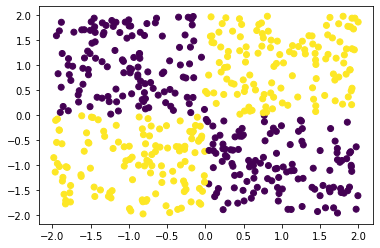

In [20]:
np.random.seed(123456)

xs = np.random.uniform(low=-2, high=2, size=1000).reshape((500,2))
ys = np.zeros(500)
ys[np.logical_and(xs[:,0]>0, xs[:,1]>0)]=1
ys[np.logical_and(xs[:,0]<0, xs[:,1]<0)]=1

plt.scatter(xs[:,0], xs[:,1], c=ys)

4. We fit the network on the data with gradient descent, and we plot the total loss at each iteration.

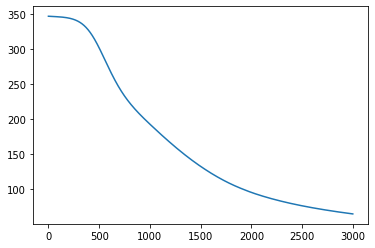

In [21]:
xs = np.asmatrix(xs)
ys = np.asmatrix(ys).reshape((500,1))

trajectories_standard, losses_standard = gradient_descent(xs, ys, params_init,
                                        iterations=3000, lr=1e-4)
plt.plot(losses_standard)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Gradient Descent")
plt.show()

5. We repeat the exercise for gradient descent with momentum.

In [22]:
def gradient_descent_momentum(x, y, starting_params, iterations, lr, alpha):
    """Perform gradient descent"""
    W, b, v, c = starting_params
    trajectories = [starting_params]
    losses = [loss(y, yhat(x, starting_params)[1])]
    velocities = [np.zeros((2,3)), np.zeros((1,3)), np.zeros((3,1)), 0.0]

    for i in range(iterations):
        grad = grad_f(starting_params, x, y)
        velocities = [alpha * v + lr * g for v, g in zip(velocities, grad)]
        starting_params = [weight - x for weight, x
                           in zip(starting_params, velocities)]
        trajectories.append(starting_params)
        losses.append(loss(y, yhat(x, starting_params)[1]))

    return (trajectories, losses)

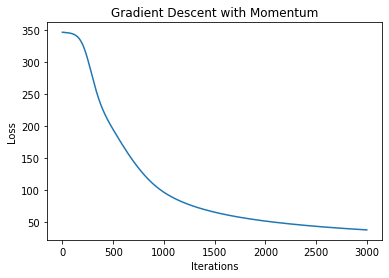

In [32]:
trajectories_momentum, losses_momentum = gradient_descent_momentum(xs, ys, params_init,
                                        iterations=3000, lr=1e-4, alpha=0.5)
plt.plot(losses_momentum)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Gradient Descent with Momentum")
plt.show()

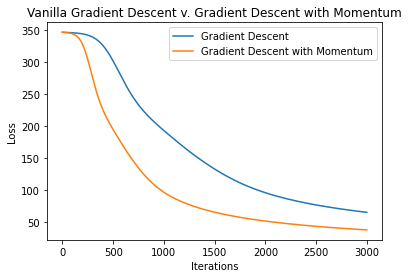

In [31]:
plt.plot(losses_standard, label="Gradient Descent")
plt.plot(losses_momentum, label="Gradient Descent with Momentum")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Vanilla Gradient Descent v. Gradient Descent with Momentum")
plt.legend()
plt.show()

For the same number of iterations and the same learning rate, the momentum method allows gradient descent to converge faster. The plot demonstrates this for this specific optimization problem.

6. We plot a visualization of the final decision boundary and overlay it on the XOR dataset.

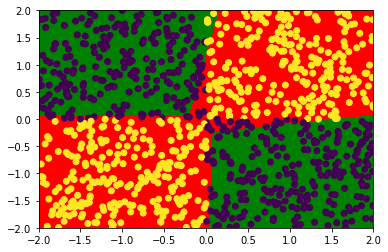

In [36]:
# To obtain the decision boundary, retrieve the parameter set from
# the neural network that is received at the end of training
W_final, b_final, v_final, c_final = trajectories_momentum[-1]

# Generate XOR dataset
Xs = np.random.uniform(low=-2.0, high=2.0, size=1000).reshape((1000,1))
Ys = np.random.uniform(low=-2.0, high=2.0, size=1000).reshape((1000,1))
Zs = np.logical_xor(Xs<0, Ys>0).reshape((1000,1))
    
XOR = np.concatenate((Xs, Ys, Zs), axis=1)

x = np.linspace(-2, 2, 250).reshape(250,1)
y = np.linspace(-2, 2, 250).reshape(250,1)
Z = np.zeros(250*250).reshape(250,250)

# Given the XOR dataset, compute the decision boundary learned by the network
for countx, i in enumerate(x):
    for county, j in enumerate(y):
        temp = np.array([i[0],j[0]])
        Z[countx][county] = ff_nn_relu(np.array([i[0],j[0]]), 
                                       W_final, b_final, v_final, c_final)

X, Y = np.meshgrid(x, y)

cmap = colors.ListedColormap(['green', 'red'])
plt.contourf(X, Y, Z, cmap=cmap)
plt.scatter(Xs, Ys, c=Zs)
plt.show()

As we can see, gradient descent learns a reasonable decision boundary for the XOR dataset.